In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

In [3]:
def outlier_cells(X, num_mads=5):
    outliers = ((X < np.median(X) - num_mads * median_abs_deviation(X)
                 )
                | (np.median(X) + num_mads * median_abs_deviation(X) < X))
    return outliers


# function to normalize data
def norm_cpm(X):
    # Calculate the total read counts per cells
    total_counts_per_cell = np.sum(X, axis=1)
    
    # Calculate the total read counts per million (CPM) for each sample
    total_counts_per_million = total_counts_per_cell / 1e6
    
    # Divide the count matrix by the total counts per million for each sample
    return X / total_counts_per_million[:, np.newaxis]

def norm_log(X):
    # Calculate the total counts per cell
    total_counts_cell = np.sum(X, axis=1)

    # Calculate the median of total counts
    med_total_counts = np.median(total_counts_cell)

    # Scale the total counts
    scaled_counts = (X / total_counts_cell[:, np.newaxis]) * med_total_counts

    # Logarithm transformation
    return np.log1p(scaled_counts)


# Feature selection

def HVGs(data, top_proportion, num_genes, flavor='cell_ranger'):
    """
    Parameters:
        - top_proportion: percentages of top highly variable genes to keep (None or percentage)
        - num_genes: number of genes to keep (None or int)
        - flavor: 'seurat' or 'cell_ranger'. Determines the method used for calculating dispersion.
    """
    # Calculate mean and dispersion
    mean_expr = np.mean(data, axis=0)
    dispersion = np.var(data, axis=0) / mean_expr if flavor == 'seurat' else np.var(data, axis=0)

    # Get the number of genes to select
    if top_proportion is not None:
        num_genes = int(top_proportion * data.shape[1])

    # Get indices of top highly variable genes
    hvg_indices = np.argsort(dispersion)[::-1][:num_genes]

    return hvg_indices

# Preprocessing
def preprocess_X(X, y=None, quality_control=True):
    if (quality_control == True) & (y is not None):
        # Quality control
        total_cell_counts = X.sum(axis=1)  # total counts per cell
        # Number of expressed genes in a cell
        number_genes_by_counts = (X > 0).sum(axis=1)
        log1p_total_cells_counts = np.log1p(total_cell_counts)
        log1p_number_genes_by_counts = np.log1p(number_genes_by_counts)

        # Identify the top 20 genes
        top20_genes = np.argsort(np.array(X.sum(axis=0)).ravel())[::-1][:20]
        # Calculate the total counts in the top 20 genes for each cell
        total_counts_top20_genes = np.sum(X[:, top20_genes], axis=1)
        # Calculate the percentage of counts in the top 20 genes for each cell
        pct_counts_top20_genes = total_counts_top20_genes / total_cell_counts
        # Identify and remove poor quality cells
        cells_remove = (outlier_cells(log1p_total_cells_counts, 5)
                        | outlier_cells(log1p_number_genes_by_counts, 5)
                        | outlier_cells(pct_counts_top20_genes, 5))
        X = X[(~cells_remove), :].copy()
        y = y[~cells_remove].copy()

    # Normalization the total counts per cell
    X_norm = norm_log(X)

    # add new total genes of each cells
    # X_norm = np.column_stack((X_norm, X.sum(axis=1)))

    return (X_norm, y) if y is not None else X_norm

# Loading data

In [4]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

# convert to array
X_train = X_train.toarray()
X_train

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Data Preprocessing

**Normalization data and feature selection with highly variable genes**

In [5]:
X_bd_train, X_bd_valid, y_bd_train, y_bd_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
# X normalization 
X_bd_train, y_bd_train= preprocess_X(X_bd_train, y_bd_train, quality_control=True)
X_bd_valid = preprocess_X(X_bd_valid, quality_control=False)

<AxesSubplot: ylabel='Density'>

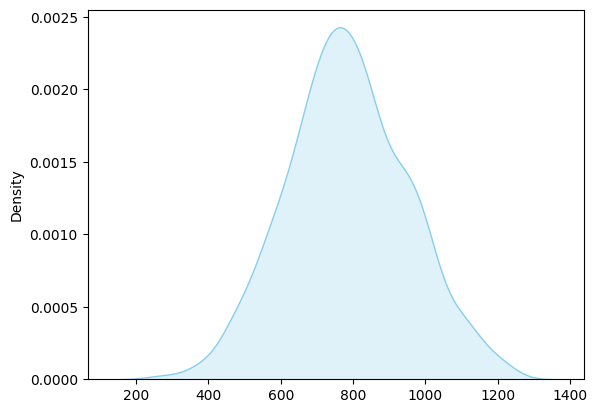

In [7]:
sns.kdeplot(X_bd_train.sum(axis=1), color='skyblue', fill=True)

# **Models Selection**

## Top 20% genes with HVG

In [8]:
# select the top 8000 genes
ind_20 = HVGs(X_train, top_proportion=0.2, num_genes=None)
X_20_train = X_bd_train[:, ind_20]
X_20_valid = X_bd_valid[:, ind_20]

**Training models**

In [9]:
# Fitting model
def training(X_train, y_train):
    # Ridge classifier
    ridge_clf = RidgeClassifier(random_state=42)
    ridge_clf.fit(X_train, y_train)

    # Logistic Regression 
    logistic_clf = LogisticRegression(solver='saga')
    logistic_clf.fit(X_train, y_train)

    # Stochastic gradient descent
    sgd_clf = SGDClassifier(random_state=42)
    sgd_clf.fit(X_train, y_train)

    # Decision tree
    decision_clf = DecisionTreeClassifier(random_state=42)
    decision_clf.fit(X_train, y_train)

    # Bagging
    bagging_clf = BaggingClassifier(random_state=42)
    bagging_clf.fit(X_train, y_train)

    # Random forest
    forest_clf = RandomForestClassifier(random_state=42)
    forest_clf.fit(X_train, y_train)

    # Extra Trees
    xrf_clf = ExtraTreesClassifier(random_state=42)
    xrf_clf.fit(X_train, y_train)

    # Gradient Boosting
    gb_clf = GradientBoostingClassifier(random_state=42)
    gb_clf.fit(X_train, y_train)

    # # AdaBoost
    ada_clf = AdaBoostClassifier(random_state=42)
    ada_clf.fit(X_train, y_train)

    # KNN
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_train)

    # Naive bayes
    gaussian_clf = GaussianNB()
    gaussian_clf.fit(X_train, y_train)

    # SVM
    svm_clf = SVC()
    svm_clf.fit(X_train, y_train)

    # OneVsRestClassifier
    OneVRest_clf = OneVsRestClassifier(SVC())
    OneVRest_clf.fit(X_train, y_train)

    # OneVsOneClassifier
    OneVOne_clf = OneVsOneClassifier(SVC())
    OneVOne_clf.fit(X_train, y_train)

    # Multi-layer Perceptron classifier
    mlp_clf = MLPClassifier(random_state=42)
    mlp_clf.fit(X_train, y_train)

    # LightGBM
    lgbm = LGBMClassifier()
    lgbm.fit(X_train, y_train)

    models= [('Ridge', ridge_clf), ('Logistic', logistic_clf), ('SGD', sgd_clf),
         ('Decision Tree', decision_clf), ('Bagging', bagging_clf), ('Random Forest', forest_clf),
         ('Extra Trees', xrf_clf), ('AdaBoost', ada_clf), ('Gradient Boosting', gb_clf),
         ('KNN', knn_clf), ('Naive Bayes', gaussian_clf), ('SVM', svm_clf), 
         ('One vs the rest', OneVRest_clf), ('One vs one', OneVOne_clf),  
         ('Multi-layer Perceptron', mlp_clf), ('Light GBM', lgbm)
        ]
    
    return models

**Fitting model**

In [10]:
models = training(X_20_train, y_bd_train)

In [11]:
score_dict = dict()
for i, model in models:
    predictions = model.predict(X_20_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_20_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8242872807017544


Cross Validation Score of  Ridge is :  0.8119712379642866
------------------------------------------------------------
Balanced score of  Logistic is:  0.8813795853269537
Cross Validation Score of  Logistic is :  0.8262512433316804
------------------------------------------------------------
Balanced score of  SGD is:  0.8372458133971292
Cross Validation Score of  SGD is :  0.8390941726343911
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.6397848313966735
Cross Validation Score of  Decision Tree is :  0.7132496582595887
------------------------------------------------------------
Balanced score of  Bagging is:  0.6843458077010709
Cross Validation Score of  Bagging is :  0.7706877914176822
------------------------------------------------------------
Balanced score of  Random Forest is:  0.7283941387559809
Cross Validation Score of  Random Forest is :  0.7097229951996585
------------------------------------------------------------
Bal

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation with non-scaled top 20% genes data')

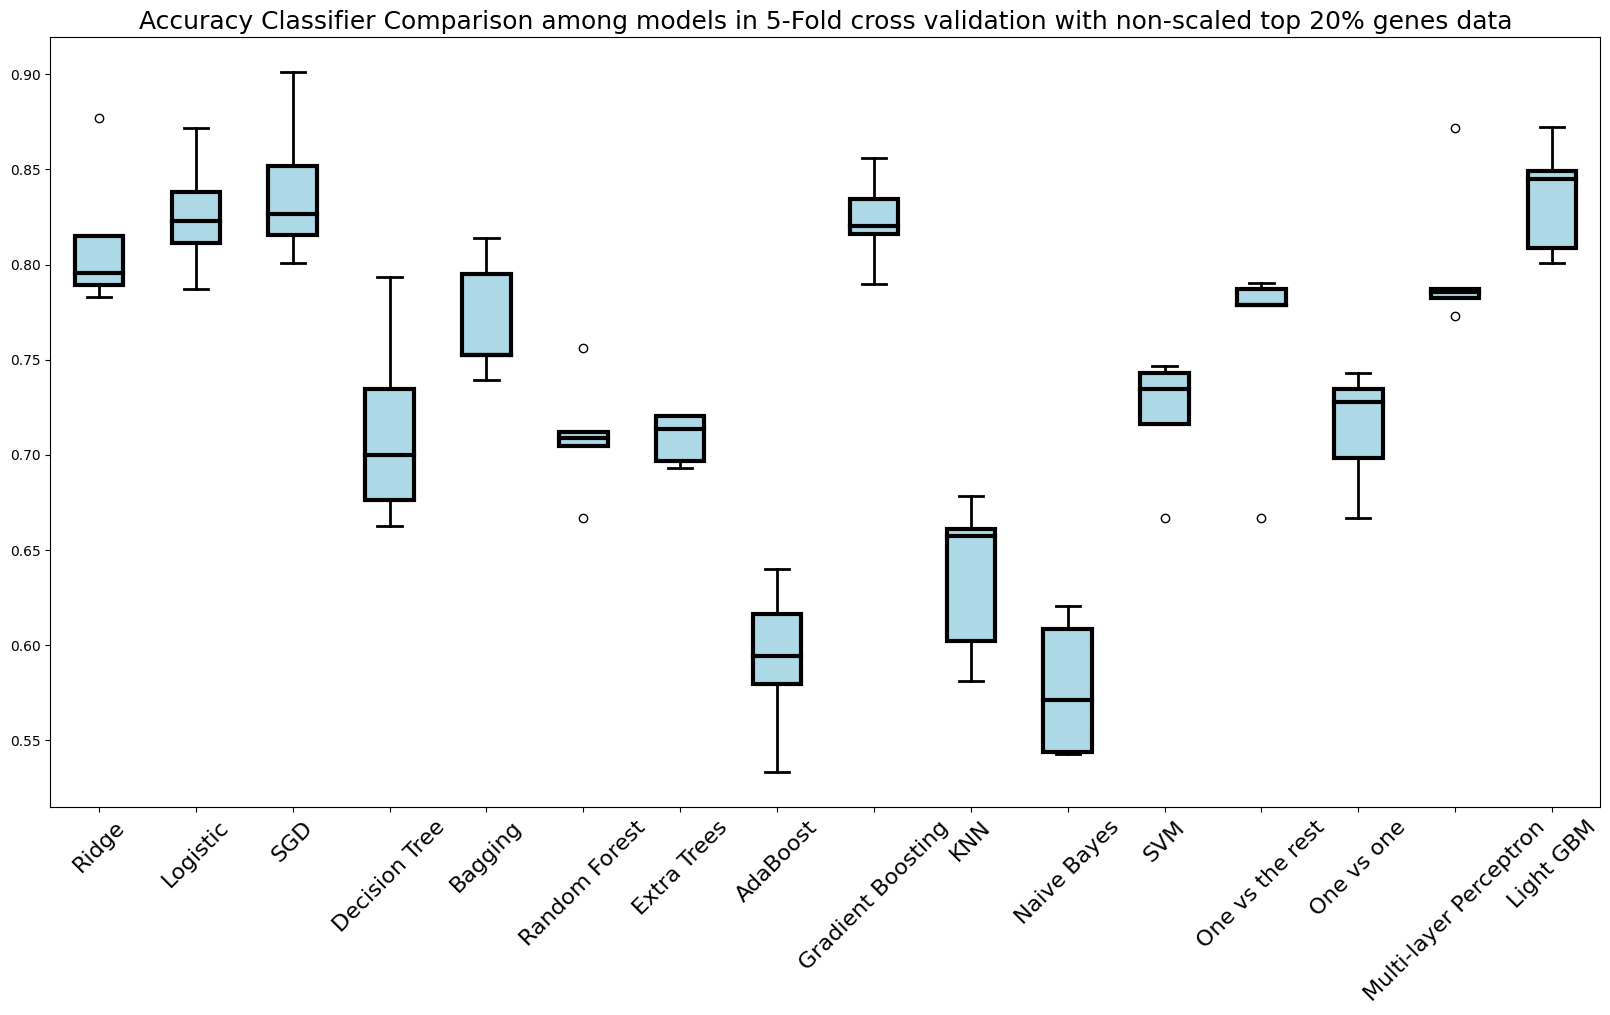

In [12]:
# Draw boxplot 
label = list(score_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among models in 5-Fold cross validation with non-scaled top 20% genes data", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: LightGBM, Logistic Regression, SGD, Gradient Boosting, Ridge Classifier, and Multi-Layer Perceptron (MLP) 

**With scale data**

In [25]:
scaler = StandardScaler()
X_20_train_scale = scaler.fit_transform(X_20_train)
X_20_valid_scale = scaler.fit_transform(X_20_valid)
models_scale = training(X_20_train_scale, y_bd_train)

score_dict = dict()
for i, model in models:
    predictions = model.predict(X_20_valid_scale)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_20_train_scale, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.7993670255183413
Cross Validation Score of  Ridge is :  0.8037846288839339
------------------------------------------------------------
Balanced score of  Logistic is:  0.8348036283891547
Cross Validation Score of  Logistic is :  0.8455316852039791
------------------------------------------------------------
Balanced score of  SGD is:  0.8560356858054227
Cross Validation Score of  SGD is :  0.8438128362656665
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.46355946684894056
Cross Validation Score of  Decision Tree is :  0.7132496582595887
------------------------------------------------------------
Balanced score of  Bagging is:  0.3896103896103896
Cross Validation Score of  Bagging is :  0.7706877914176822
------------------------------------------------------------
Balanced score of  Random Forest is:  0.6271182216905902
Cross Validation Score of  Random Forest is :  0.7097229951996585
--------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among model in 5-Fold cross validation with scaled top 20% genes data')

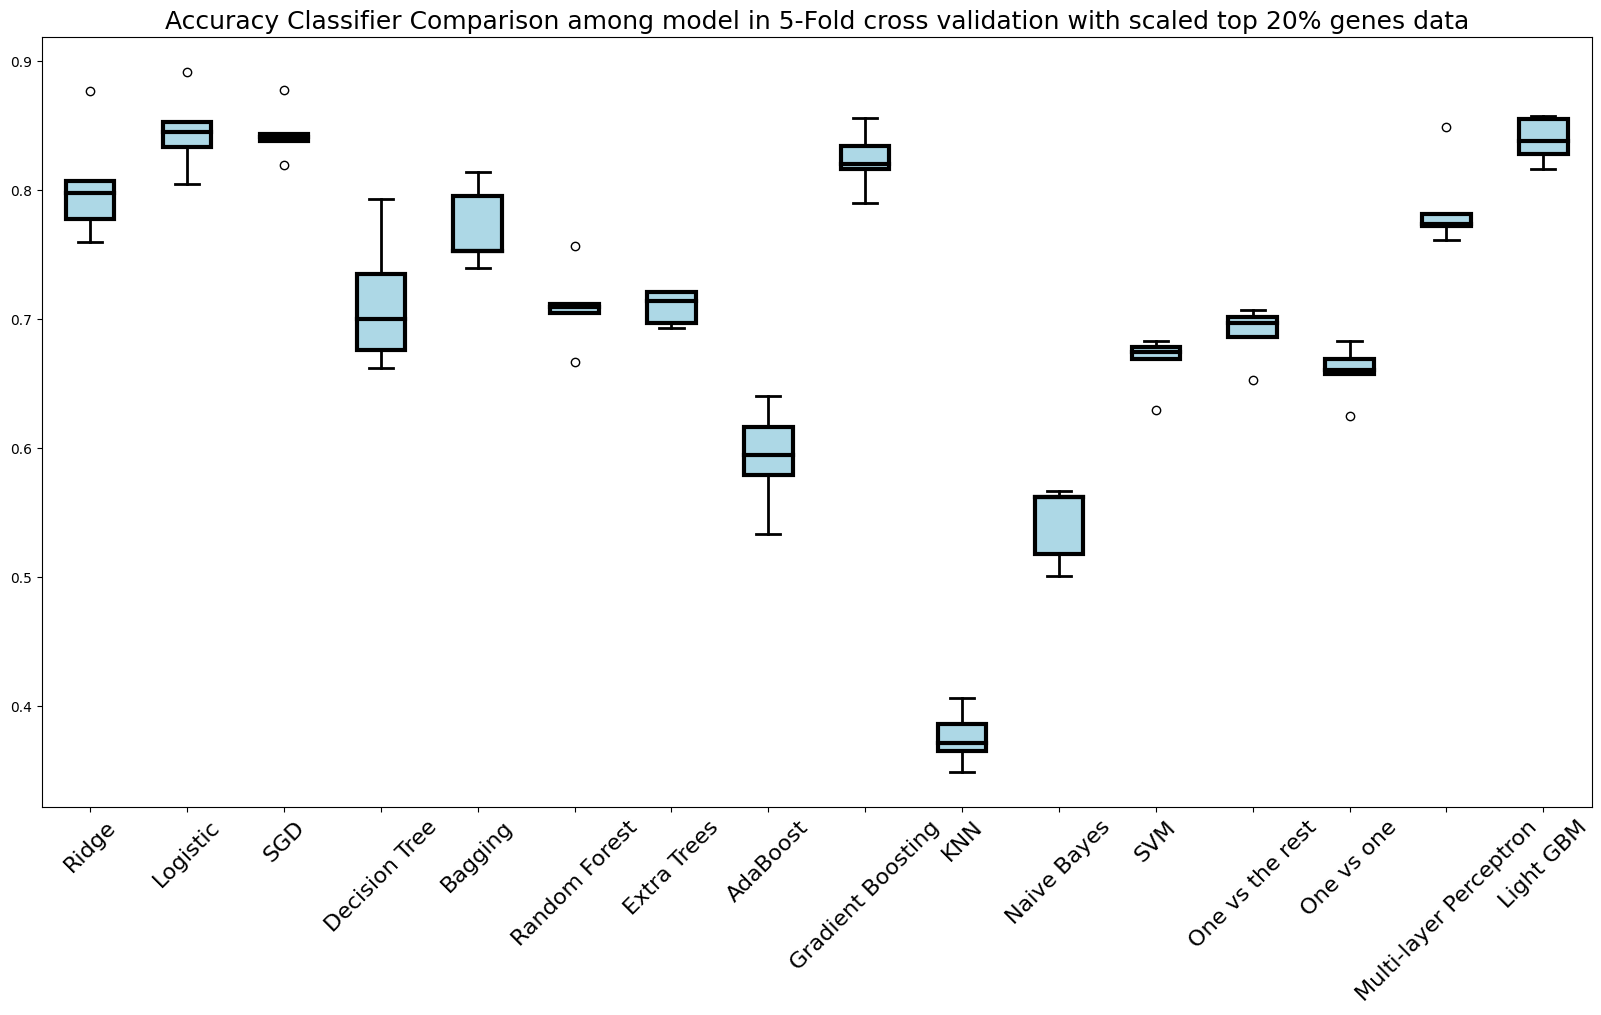

In [26]:
# Draw boxplot 
label = list(score_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among model in 5-Fold cross validation with scaled top 20% genes data", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: LightGBM, Logistic Regression, SGD, Gradient Boosting, Ridge Classifier, and Multi-Layer Perceptron (MLP)

## Top 10% genes

In [13]:
# select the top 10% genes
ind_10 = HVGs(X_train, top_proportion=0.1, num_genes=None)
X_10_train = X_bd_train[:, ind_10]
X_10_valid = X_bd_valid[:, ind_10]

In [14]:
models_10 = training(X_10_train, y_bd_train)

In [15]:
score_10_dict = dict()
for i, model in models_10:
    predictions = model.predict(X_10_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_10_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_10_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8233972715880611


Cross Validation Score of  Ridge is :  0.7565614371969882
------------------------------------------------------------
Balanced score of  Logistic is:  0.8639354066985646
Cross Validation Score of  Logistic is :  0.8245660817905108
------------------------------------------------------------
Balanced score of  SGD is:  0.8706887958532695
Cross Validation Score of  SGD is :  0.8488624702378427
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.5873882148553201
Cross Validation Score of  Decision Tree is :  0.7163309377559626
------------------------------------------------------------
Balanced score of  Bagging is:  0.7117260480747323
Cross Validation Score of  Bagging is :  0.751739573363208
------------------------------------------------------------
Balanced score of  Random Forest is:  0.6900667862838915
Cross Validation Score of  Random Forest is :  0.7209943601949561
------------------------------------------------------------
Bala

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation with non-scaled top 10% genes data')

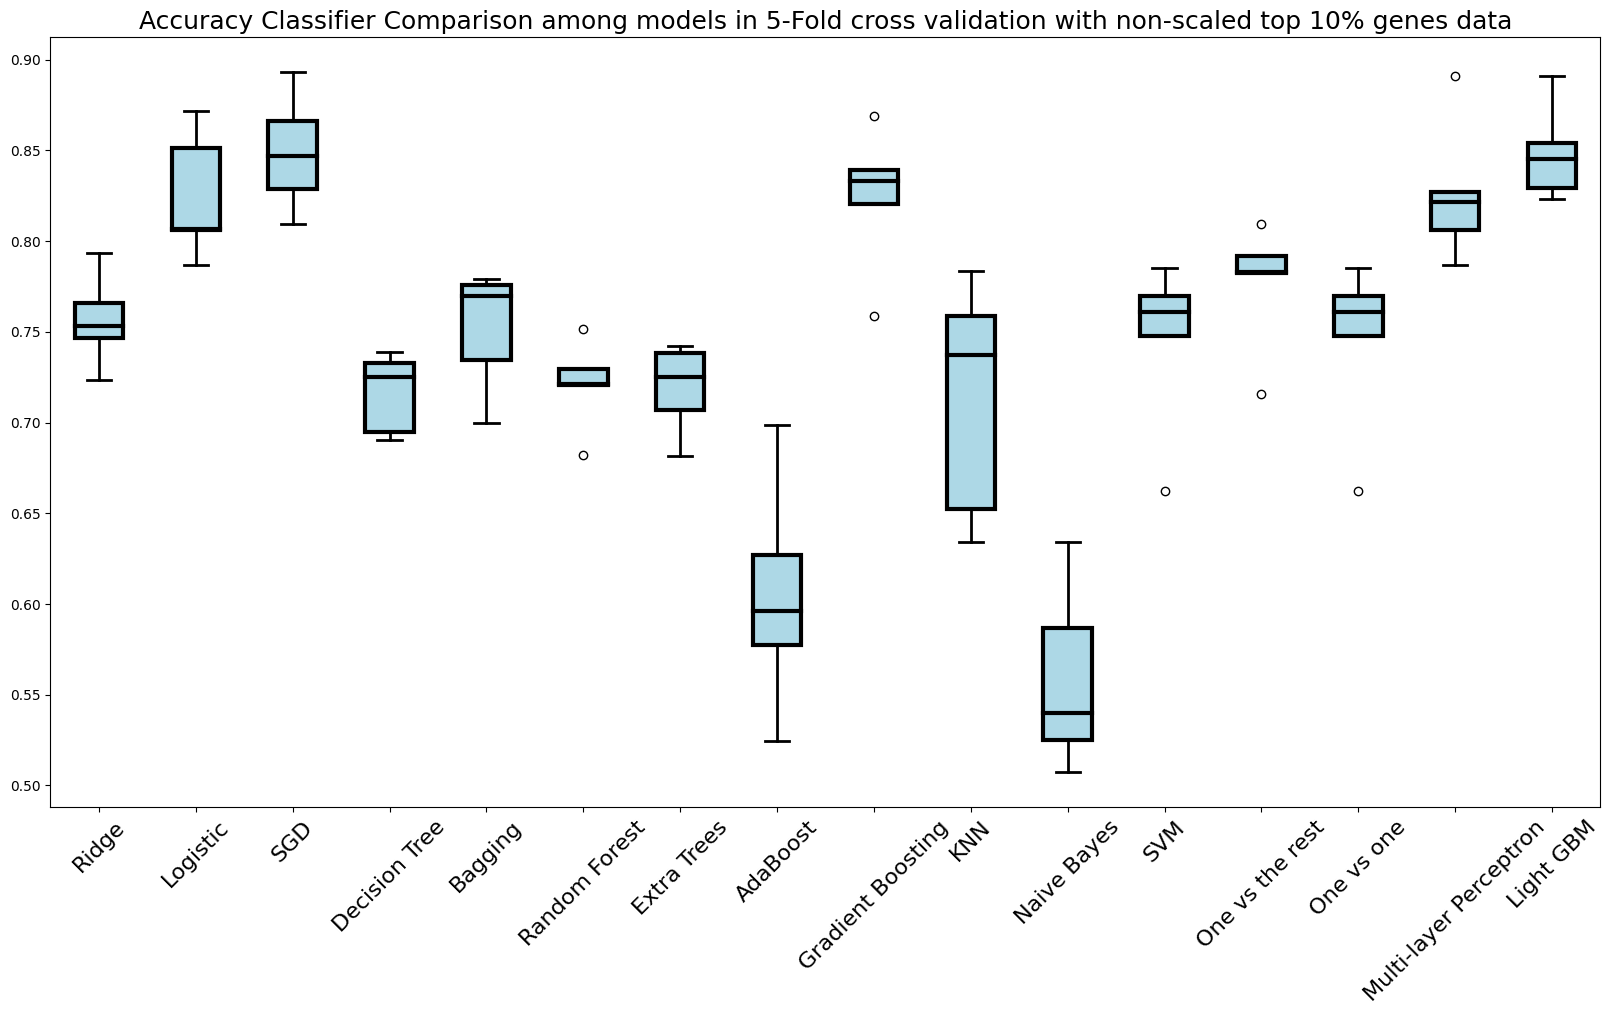

In [16]:
# Draw boxplot 
label = list(score_10_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_10_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among models in 5-Fold cross validation with non-scaled top 10% genes data", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: LightGBM, Logistic Regression, SGD, Gradient Boosting, and Multi-Layer Perceptron (MLP) 

**With scale data**

In [31]:
scaler = StandardScaler()
X_10_train_scale = scaler.fit_transform(X_10_train)
X_10_valid_scale = scaler.fit_transform(X_10_valid)
models_10_scale = training(X_10_train_scale, y_bd_train)

score_10_dict = dict()
for i, model in models_10_scale:
    predictions = model.predict(X_10_valid_scale)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, X_10_train_scale, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_10_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  Ridge is:  0.8083988380041012
Cross Validation Score of  Ridge is :  0.7719247934491231
------------------------------------------------------------
Balanced score of  Logistic is:  0.8606459330143541
Cross Validation Score of  Logistic is :  0.8357638168958923
------------------------------------------------------------
Balanced score of  SGD is:  0.8019088915470494
Cross Validation Score of  SGD is :  0.8050585159075725
------------------------------------------------------------
Balanced score of  Decision Tree is:  0.6015429197994987
Cross Validation Score of  Decision Tree is :  0.7163309377559626
------------------------------------------------------------
Balanced score of  Bagging is:  0.7155139268626112
Cross Validation Score of  Bagging is :  0.751739573363208
------------------------------------------------------------
Balanced score of  Random Forest is:  0.7251046650717704
Cross Validation Score of  Random Forest is :  0.7209943601949561
----------------

Text(0.5, 1.0, 'Accuracy Classifier Comparison among models in 5-Fold cross validation with scaled top 10% genes data')

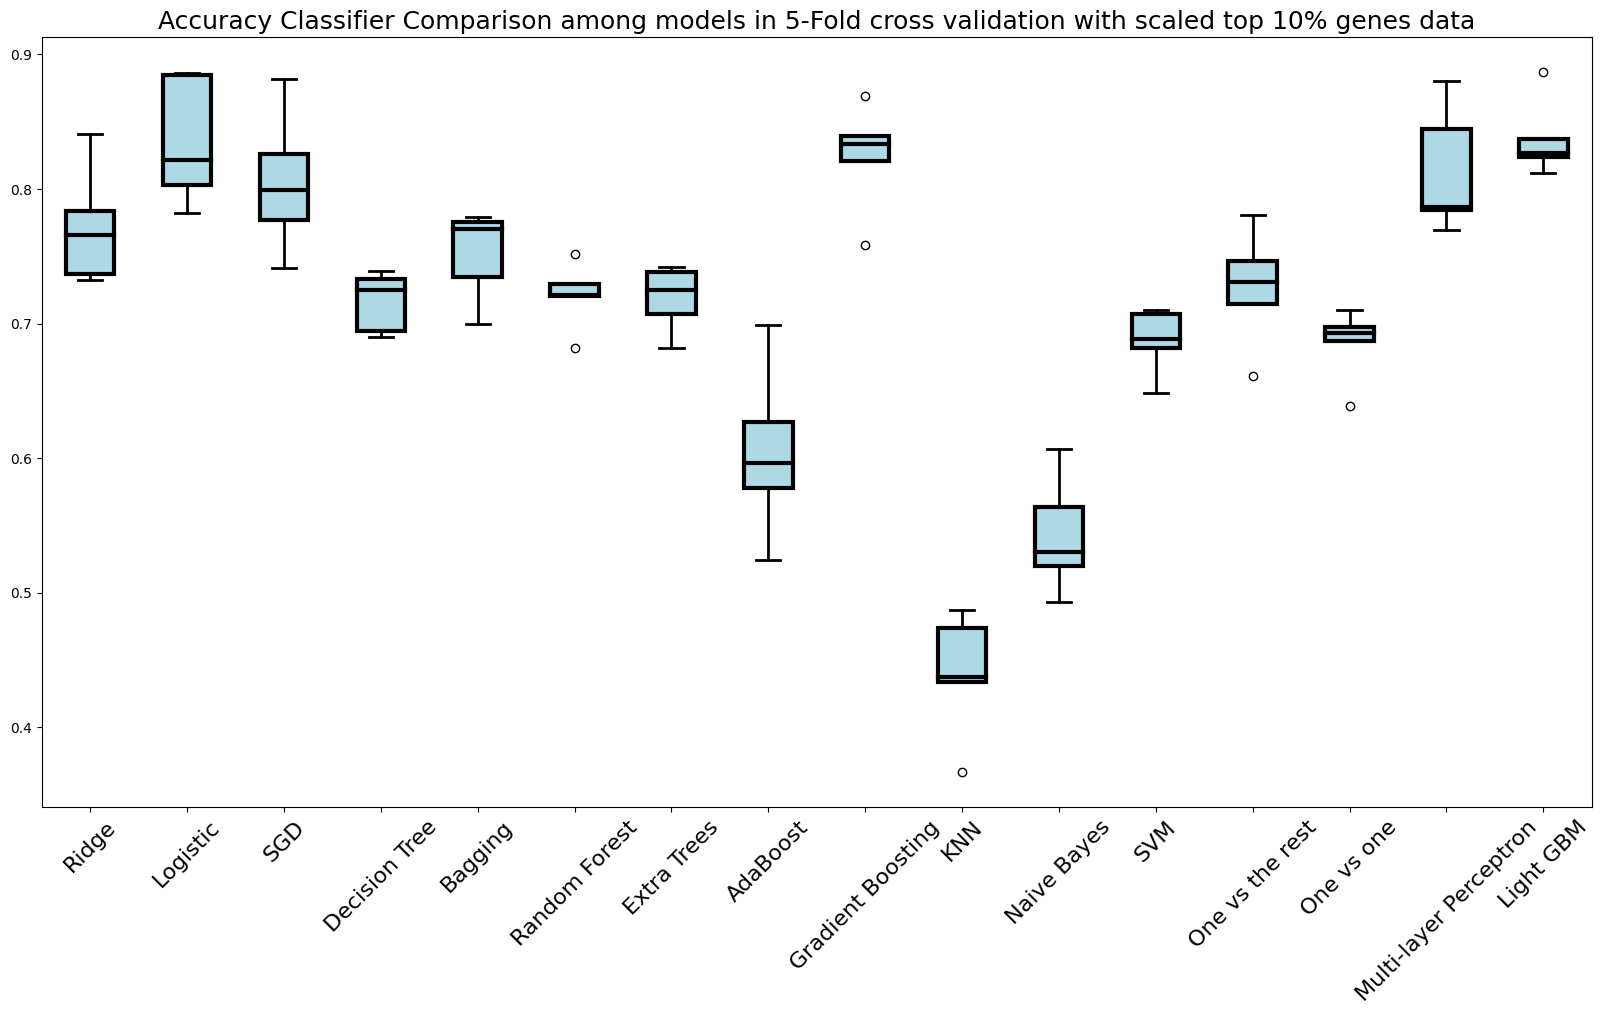

In [32]:
# Draw boxplot 
label = list(score_10_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_10_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among models in 5-Fold cross validation with scaled top 10% genes data", fontsize=18)

Regarding the boxplots, we can see several models that have potential in classification: LightGBM, Logistic Regression, SGD, Gradient Boosting, and Multi-Layer Perceptron (MLP) 

## **Stacking Classifier**

We try to stack all potential models to increase the balance accuracy. After trying many combinations on RAMP, we found out the best one below. We use it to test with the local data and making the confusion matrix

In [17]:
estimators = [
    ('ridge', RidgeClassifier(random_state=42)),
    ('sgd', SGDClassifier(random_state=42)),
    ('mlp', make_pipeline(StandardScaler(), MLPClassifier(random_state=42))),
    ('xrf', ExtraTreesClassifier(n_estimators=100, random_state=42)), 
    ('gb', GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_features="log2")),
    ('lgbm', LGBMClassifier(learning_rate=0.5, verbose=-100, n_jobs=-1))
    ]

# black_bull_g with HVGs top 10% genes data: 0.87 on RAMP Studio, train time: 270.212576
stack10 = StackingClassifier(estimators=estimators, final_estimator=make_pipeline(StandardScaler(), LogisticRegression()))
stack10.fit(X_10_train, y_bd_train)
# black_bull_g with HVGs top 20% genes: 0.89 on RAMP Studio, train time: 310.191439, validation time: 2.234147 (best model submitted on RAMP)
stack20 = StackingClassifier(estimators=estimators, final_estimator=make_pipeline(StandardScaler(), LogisticRegression()))
stack20.fit(X_20_train, y_bd_train)

StackingClassifier(estimators=[('ridge', RidgeClassifier(random_state=42)),
                               ('sgd', SGDClassifier(random_state=42)),
                               ('mlp',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('mlpclassifier',
                                                 MLPClassifier(random_state=42))])),
                               ('xrf', ExtraTreesClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_features='log2',
                                                           n_estimators=500)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.5,
                                               verbose=-100))],
                   final_estimator=Pipeline(steps=[('standardscaler',
                                                    StandardScaler()),
                                                   ('logisticregression',
                                                    LogisticRegression())]))

**Stacking Classifier:**

In [18]:
models_stack = [
    ('stack 10%', stack10, X_10_train, X_10_valid), # stack model train on HGV 10% top genes data
    ('stack 20%', stack20, X_20_train, X_20_valid), # stack model train on HGV 20% top genes data
]

score_stack_dict = dict()
for i, model, x_train, x_valid in models_stack:
    predictions = model.predict(x_valid)
    accuracy = balanced_accuracy_score(y_bd_valid, predictions)
    print('Balanced score of ', i , 'is: ',accuracy)
    cv_score = cross_val_score(model, x_train, y_bd_train.to_numpy(), cv=5, n_jobs=-1, scoring='balanced_accuracy')
    score_stack_dict[i] = cv_score
    print('Cross Validation Score of ', i , 'is : ' ,cv_score.mean())
    print('--'*30)

Balanced score of  stack 10% is:  0.877591706539075
Cross Validation Score of  stack 10% is :  0.8480832685648971
------------------------------------------------------------
Balanced score of  stack 20% is:  0.8936901913875599
Cross Validation Score of  stack 20% is :  0.866535977906385
------------------------------------------------------------


Text(0.5, 1.0, 'Accuracy Classifier Comparison among stack models in 5-Fold cross validation')

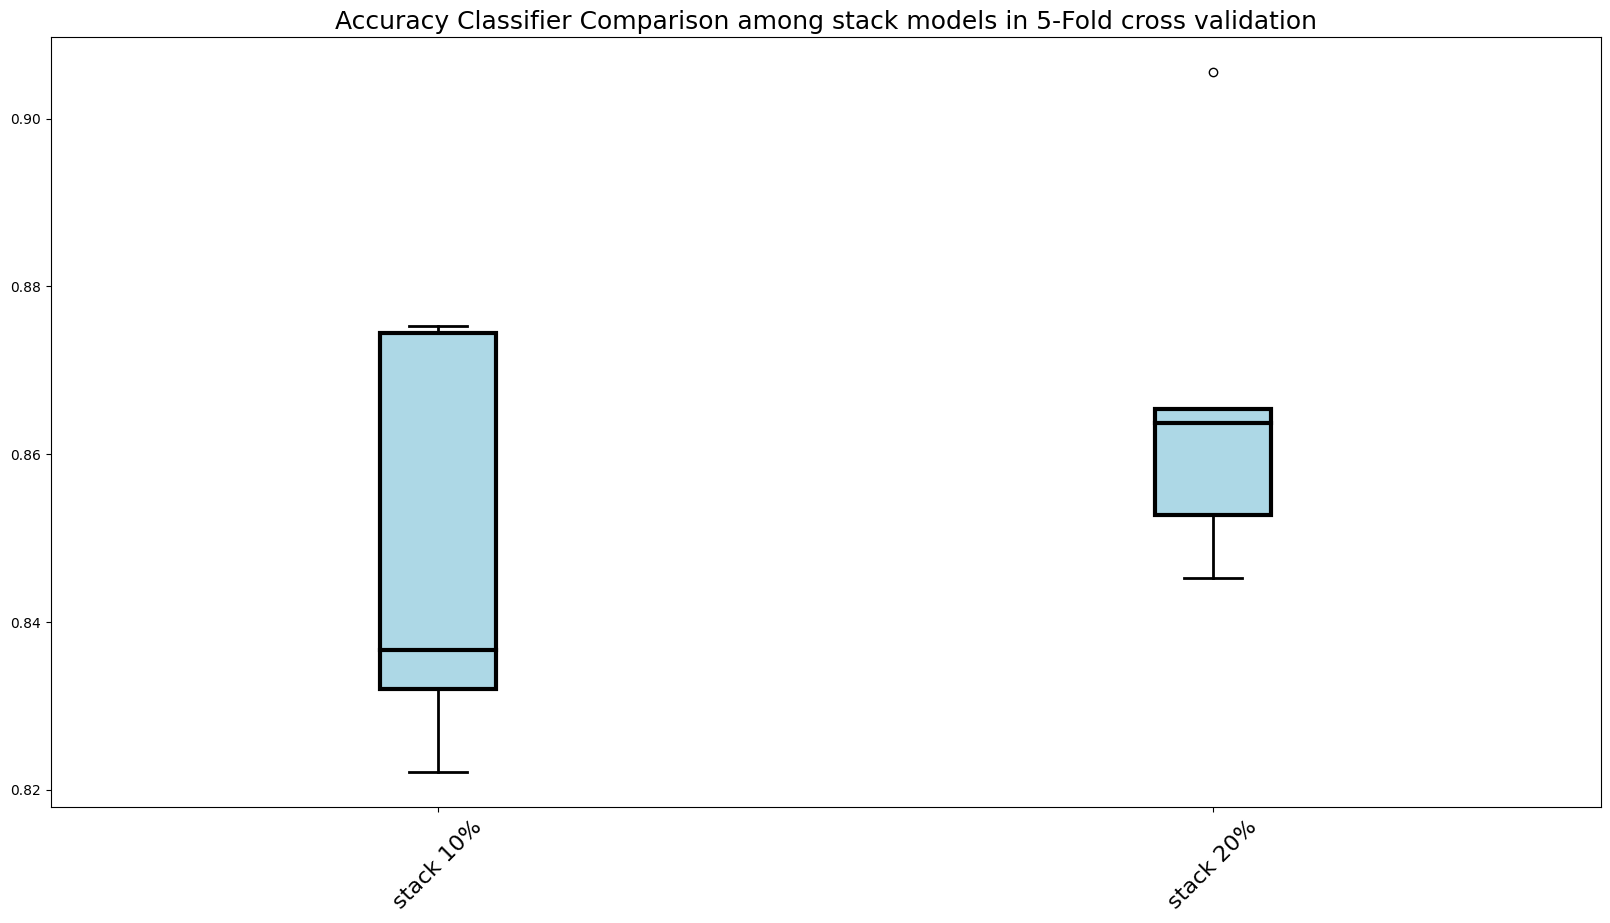

In [19]:
# Draw boxplot 
label = list(score_stack_dict.keys())
plt.figure(figsize=(20, 10))
bplot =plt.boxplot(list(score_stack_dict.values()), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=3.0),
                   capprops=dict(linewidth=2.0),
                   whiskerprops=dict(linewidth=2.0),
                   flierprops=dict(linewidth=2.0),
                   medianprops=dict(linewidth=3.0, color = 'black'))
plt.xticks(np.arange(len(label))+1, label, fontsize=16, rotation = 45,)
plt.title("Accuracy Classifier Comparison among stack models in 5-Fold cross validation", fontsize=18)

# **Testing data**

In [21]:
# Prediction on testing data
X_bd_test = preprocess_X(X_test.toarray(), quality_control=False)
X_10_test = X_bd_test[:, ind_10]
X_20_test = X_bd_test[:, ind_20]

<AxesSubplot: ylabel='Density'>

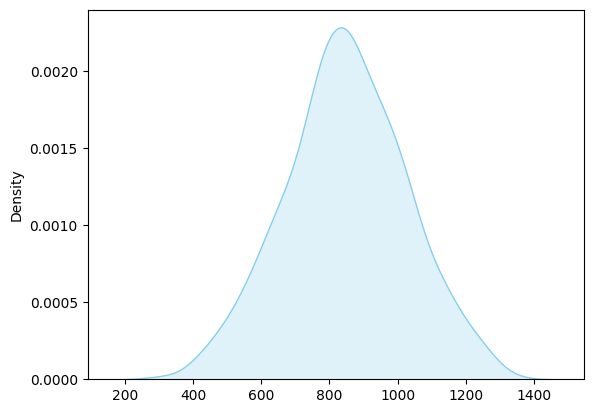

In [22]:
sns.kdeplot(X_bd_test.sum(axis=1), color='skyblue', fill=True)

In [2]:
# models_4k

In [23]:
best_models = [
    ('Stacking 10%', stack10, X_10_test),
    ('Stacking 20%', stack20, X_20_test),
]

In [24]:
y_pred = []
for i, model, X_test in best_models:
    predictions = model.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, predictions)
    y_pred.append(predictions)
    print('Accuracy of ', i , 'is: ',accuracy)
    print('--'*30)

Accuracy of  Stacking 10% is:  0.8154314577832045
------------------------------------------------------------
Accuracy of  Stacking 20% is:  0.8569684644702019
------------------------------------------------------------


In [25]:
ytr_10_pred = stack10.predict(X_10_train)
ytr_20_pred = stack20.predict(X_20_train)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.815


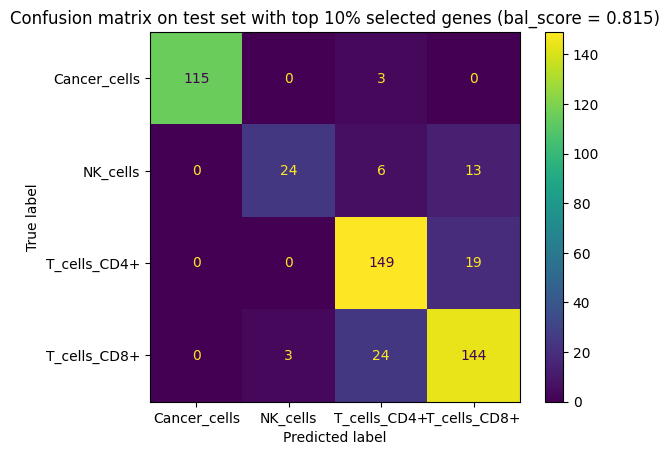

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_bd_train, ytr_10_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_pred[0]):.3f}")
cm = confusion_matrix(y_test, y_pred[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack10.classes_, )
disp.plot()
plt.title(f"Confusion matrix on test set with top 10% selected genes (bal_score = {balanced_accuracy_score(y_test, y_pred[0]):.3f})");

Train balanced accuracy : 1.000
Test balanced accuracy : 0.857


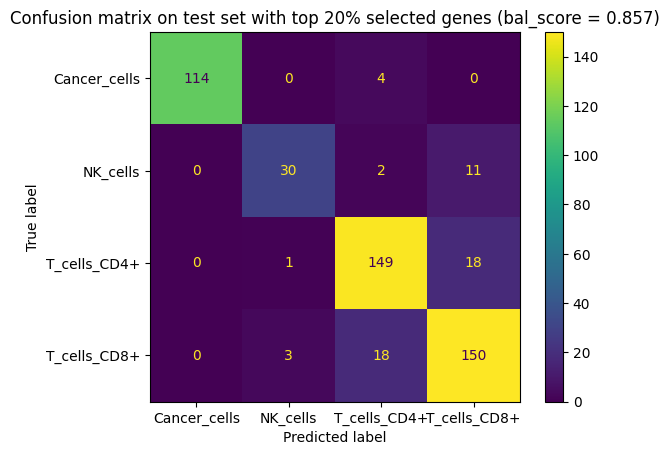

In [31]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_bd_train, ytr_20_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_pred[1]):.3f}")
cm = confusion_matrix(y_test, y_pred[1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack20.classes_, )
disp.plot()
plt.title(f"Confusion matrix on test set with top 20% selected genes (bal_score = {balanced_accuracy_score(y_test, y_pred[1]):.3f})");

# GridSearchCV

In [101]:
# Function to do grid search 
def grid_cv(params_grid, model, X, y, k):
    grid_search = GridSearchCV(model, params_grid, scoring='balanced_accuracy', cv=k, n_jobs=-1, refit=True, verbose=1)
    grid_search.fit(X, y)

    best_params = grid_search.cv_results_['params'][grid_search.best_index_]
    best_score = grid_search.best_score_
    print('The best hyper-parameters are {0}, with accuracy = {1}.'.format(best_params, best_score))